# 02 - Data Exploration and Feature Engineering Notebook 

https://www.kdnuggets.com/2019/05/complete-exploratory-data-analysis-visualization-text-data.html

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction import text 
from wordcloud import WordCloud, STOPWORDS

import pickle
import os

pd.set_option('display.max_columns', None)

In [2]:
def load_pickle_obj(cache_file, cache_folder = "../cache", data_folder = "lyrics"):
    '''
    helper function to load or dump pickle objects so I don't need to rerun code everytime I open the notebook
    -------------------------------------------------------
    arguments:
        cache_file (str): name of the .pkl file to load
        cache_folder (str): main path for cache folder
        data_folder (str): subfolder of cache folder 
        
    '''
    
    cache_dir = os.path.join(cache_folder, data_folder)
    
    if not os.path.exists(cache_dir):
        os.makedirs(cache_dir)
    
    # Load object - not to rerun again
    with open(os.path.join(cache_dir, cache_file), "rb") as f:
        data = pickle.load(f)
        
    return data

In [3]:
# Load object to disk - so I don't need to rerun the notebook
data = load_pickle_obj(cache_file = "preprocessed_data.pkl", cache_folder = "../cache", data_folder = "lyrics")
dict_ = load_pickle_obj(cache_file = "word_dict.pkl", cache_folder = "../cache", data_folder = "mappings")

In [51]:
data = pd.read_csv('../data/output/data_lyrics_final.csv',index_col = 'id')

In [4]:
data.tail()

,name,artists,year,lyrics,valence,lyrics_pre_proc,target,word_count
17547,Sexy Robotica,Don Omar,2021,\n (Robin)\nIdon\nC...,0.554,"[robin, la, la, super, nova, bien, se, la, con...",1,88
17548,Heaven,Julia Michaels,2021,"\n [Intro]\r\nOoh, ...",0.245,"[love, religion, faith, someth, sacr, hard, re...",0,101
17549,Issues,Julia Michaels,2021,\n [Verse 1]\r\nI'm...,0.451,"[jealou, overzeal, get, real, high, come, get,...",0,143
17550,Get Busy,Sean Paul,2021,\n Shake that thing...,0.725,"[shake, thing, miss, kana, kana, shake, thing,...",1,329
17551,A Little More,Alessia Cara,2021,\n [Verse 1]\r\nThe...,0.228,"[colleg, band, help, wish, knew, guess, know, ...",0,98


## 1 - Data Cleaning

In [53]:
data.index = range(0, data.shape[0])

### 1.1 Cleaning artists names

In [54]:
clean_artists = []

replace_dict = {"['": "", 
                "']": ""}

def replace_all(text, dic):
    for i, j in dic.items():
        text = text.replace(i, j)
    return text

for artist in list(data.artists):
    clean = replace_all(artist,replace_dict) 
    clean_artists.append(clean)
    

In [55]:
data['artists'] = clean_artists

In [56]:
data.head()

,name,artists,year,lyrics,valence
0,9 to 5,Dolly Parton,1980,\n Tumble outta bed...,0.813
1,Any Way You Want It,Journey,1980,\n Any way you want...,0.571
2,Babooshka,Kate Bush,1980,\n She wanted to te...,0.289
3,Song of the South,Alabama,1980,\n Written by Bob M...,0.669
4,Keep on Loving You,REO Speedwagon,1980,\n You should've se...,0.410


### 1.2 Removing duplicates

In [57]:
data_no_dup = data.drop_duplicates().reset_index()

print(f"We removed {data.shape[0] - data_no_dup.shape[0]} duplicated rows")

We removed 275 duplicated rows


In [58]:
data = data.drop_duplicates().reset_index(drop = True)

In [59]:
data

,name,artists,year,lyrics,valence
0,9 to 5,Dolly Parton,1980,\n Tumble outta bed...,0.813
1,Any Way You Want It,Journey,1980,\n Any way you want...,0.571
2,Babooshka,Kate Bush,1980,\n She wanted to te...,0.289
3,Song of the South,Alabama,1980,\n Written by Bob M...,0.669
4,Keep on Loving You,REO Speedwagon,1980,\n You should've se...,0.410
...,...,...,...,...,...
17547,Sexy Robotica,Don Omar,2021,\n (Robin)\nIdon\nC...,0.554
17548,Heaven,Julia Michaels,2021,"\n [Intro]\r\nOoh, ...",0.245
17549,Issues,Julia Michaels,2021,\n [Verse 1]\r\nI'm...,0.451
17550,Get Busy,Sean Paul,2021,\n Shake that thing...,0.725


### 1.3 Cleaning song lyrics

In [60]:
data['lyrics'][3000]

'\n                            Out in the garden\nThere\'s half of a heaven,\nAnd we\'re only bluffing.\nWe\'re not ones for busting through walls,\nBut they\'ve told us\nUnless we can prove\nThat we\'re doing it,\nWe can\'t have it all.\n"I want it all"\n\nHe\'s gonna wangle\nA way to get out of it.\nShe\'s an excuse\nAnd a witness who\'ll talk when he\'s called.\nBut they\'ve told us\nUnless we can prove\nThat we\'re doing it,\nWe can\'t have it all.\n"I want it all, and I want it all"\nWe can\'t have it all.\n"I want it all"\n\n"I caught a glimpse of a god, all shining and bright."\n\nSuddenly my feet are feet of mud.\nIt all goes slo-mo.\nI don\'t know why I\'m crying.\nAm I suspended in gaffa?\nNot \'til I\'m ready for you,\nNot \'til I\'m ready for you\nCan I have it all?\n\nI try to get nearer,\nBut as it gets clearer\nThere\'s something appears in the way,\nIt\'s a plank in me eye,\nWith a camel\nWho\'s trying to get through it,\nAm I doing it?\nCan I have it all now?\n"I want 

In [61]:
import nltk
words = set(nltk.corpus.words.words())

sent = data['lyrics'][0]
" ".join(w for w in nltk.wordpunct_tokenize(sent) if w.lower() not in words or w.isalpha())
    

"Tumble outta bed And stumble to the kitchen , Pour myself a cup of ambition ! And yawn and stretch and try to come to life , jump in the shower And the blood starts pumpin , Out on the streets The traffic starts jumpin , With folks like me on the job from 9 to 5 Workin 9 to 5 What a way to make a livin , Barely gettin by Its takin And no givin , They just use your mind And they never give you credit , Its enough to drive you Crazy if you let it , 9 to 5 , for service and devotion , You would think that I Would deserve a fair promotion , Want to move ahead But the boss wont seem to let me in , I swear sometimes that man is out to get me Mmmmm ... They let you dream Just to watch ' em shatter , Youre just a step On the boss mans a ladder , But you got dreams hell never take away , On the same boat With a lot of your friends , Waitin for the day Your ship ' ll come in , And the tides gonna turn And it ' s all gonna roll your way , 2nd chorus : Workin 9 to 5 What a way to make a livin , B

In [62]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import *

import re
from bs4 import BeautifulSoup

def lyrics_to_words(lyrics):
    '''
    helper function to clean out song lyrics. We apply porter Stemmer algorithm and remove stopwords
    '''
    stopwords = nltk.corpus.stopwords.words('english')
    newStopWords = ['verse','1', '2', 'chorus', 'bridge', 'talking', 'refrain', 'explain', 'request']
    stopwords.extend(newStopWords)
    stemmer = PorterStemmer()
    
    words_english = set(nltk.corpus.words.words())

    remove_non_english = " ".join(w for w in nltk.wordpunct_tokenize(lyrics) if w.lower() in words_english or not w.isalpha())
    
    text = re.sub(r"[^a-zA-Z0-9]", " ", remove_non_english.lower()) # Convert to lower case
    words = text.split() # Split string into words
    words = [w for w in words if w not in stopwords] # Remove stopwords
    words = [PorterStemmer().stem(w) for w in words] # stem
    
    return words

In [63]:
# TEST
lyrics_to_words(data['lyrics'][3000])

['garden',
 'half',
 'heaven',
 'told',
 'us',
 'unless',
 'prove',
 'want',
 'wangl',
 'way',
 'get',
 'excus',
 'wit',
 'talk',
 'told',
 'us',
 'unless',
 'prove',
 'want',
 'want',
 'want',
 'caught',
 'glimps',
 'god',
 'shine',
 'bright',
 'suddenli',
 'mud',
 'goe',
 'mo',
 'know',
 'cri',
 'suspend',
 'til',
 'readi',
 'til',
 'readi',
 'tri',
 'get',
 'clearer',
 'someth',
 'way',
 'plank',
 'eye',
 'camel',
 'tri',
 'get',
 'want',
 'pull',
 'plank',
 'say',
 'thank',
 'ye',
 'yank',
 'back',
 'fact',
 'alway',
 'someth',
 'distract',
 'sometim',
 'hard',
 'know',
 'right',
 'want',
 'want',
 'want',
 'dream',
 'mayb',
 'suddenli',
 'mud',
 'goe',
 'mo',
 'know',
 'cri',
 'suspend',
 'til',
 'readi',
 'til',
 'readi',
 'open',
 'told',
 'pandora',
 'much',
 'like',
 'girl',
 'mirror',
 'stand',
 'chanc',
 'get',
 'anywher',
 'want',
 'anywher',
 'want',
 'thing',
 'want',
 'mother',
 'suddenli',
 'mud',
 'goe',
 'mo',
 'know',
 'cri',
 'suspend',
 'til',
 'readi',
 'til',
 'r

In [64]:
data['lyrics_pre_proc'] = [lyrics_to_words(lyric) for lyric in data['lyrics']]

In [66]:
data.head()

,name,artists,year,lyrics,valence,lyrics_pre_proc
0,9 to 5,Dolly Parton,1980,\n Tumble outta bed...,0.813,"[tumbl, bed, stumbl, kitchen, pour, cup, ambit..."
1,Any Way You Want It,Journey,1980,\n Any way you want...,0.571,"[way, want, way, need, way, want, laugh, sing,..."
2,Babooshka,Kate Bush,1980,\n She wanted to te...,0.289,"[test, husband, knew, exactli, pseudonym, fool..."
3,Song of the South,Alabama,1980,\n Written by Bob M...,0.669,"[written, bob, song, song, south, sweet, potat..."
4,Keep on Loving You,REO Speedwagon,1980,\n You should've se...,0.410,"[seen, look, babi, known, tone, voic, mayb, li..."


### 1.3. Create target - `valence > 0.5 then 1 else 0`

In [67]:
data.columns

Index(['name', 'artists', 'year', 'lyrics', 'valence', 'lyrics_pre_proc'], dtype='object')

Text(0.5, 1.0, 'Target distribution')

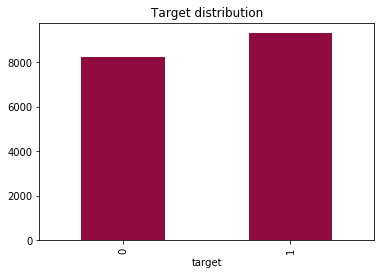

In [68]:
data['target'] = np.where(data.valence > 0.5, 1, 0)

data.groupby('target')['name'].count().plot(kind = 'bar', color = '#900C3F')
plt.title("Target distribution")

## 2. Data Exploration
We get the feeling of our lyrics and try to check how balance the data is in regards to our target

***

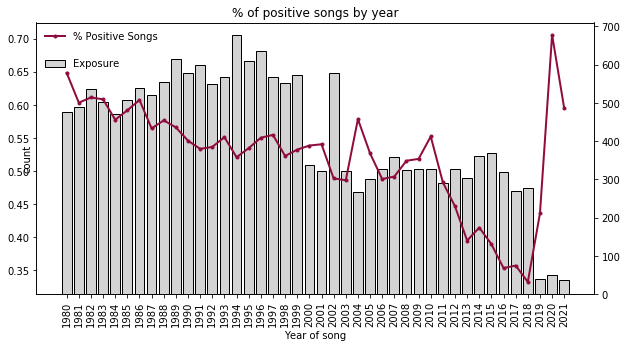

In [69]:
fig, ax1 = plt.subplots(figsize = (10,5))

data_filter = data.groupby(['year']).agg({'name': ['count'],
                                          'target': ['mean']}).reset_index()
data_filter.columns = ['year', 'count', 'target']
#data_filter.index = data_filter.year

sns.barplot(data = data_filter, x = 'year', y = 'count',label = 'Exposure', color = 'lightgray', edgecolor = 'black',
            ax = ax1)
plt.xticks(rotation=90)
ax1.set_xlabel('Year of song', fontsize = 10)
    
ax2 = ax1.twinx()
ax2.plot(ax1.get_xticks(), data_filter['target'], label = '% Positive Songs', 
         color = '#900C3F', linewidth=2, marker = '.')

ax1.legend(loc='upper left', bbox_to_anchor=(0, 0.4, 0.5, 0.5), fontsize = 'medium', edgecolor = 'white')
ax2.legend(loc='upper left', bbox_to_anchor=(0, 0.5, 0.5, 0.5), fontsize = 'medium', edgecolor = 'white')

plt.title("% of positive songs by year")

ax1.yaxis.tick_right()
ax2.yaxis.tick_left()

plt.show()

* Dividing by periods

<Figure size 720x360 with 0 Axes>

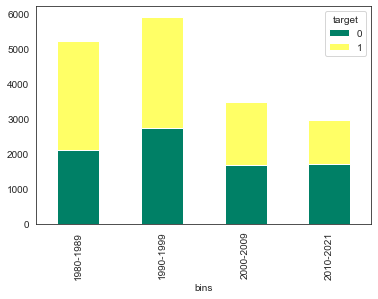

In [70]:
data_plot = data.copy()
data_plot['bins'] = np.where(data_plot.year < 1990, '1980-1989', 
                             np.where(data_plot.year < 2000, '1990-1999', 
                             np.where(data_plot.year < 2010, '2000-2009','2010-2021')))

sns.set_style(style="white")
fig = plt.figure(figsize=(10,5))
group = data_plot.groupby(['bins', 'target'])['name'].size().unstack(level=-1).reset_index()

group.plot.bar(x='bins', stacked=True, colormap='summer')
plt.show()


In [71]:
print('3 random song lyrics with a non positive mood: \n')
cl = data.loc[data.target == 1, ['lyrics', 'name', 'artists']].sample(3, random_state = 12).values
for c in cl:
    print(f"{c[1]} by {c[2]}")
    print(c[0])

3 random song lyrics with a non positive mood: 

Crystal by Elton John

                            We're caught up in a web, you and I
Since Crystal came between us
The knots of friendship seem to be untied
And it hurts me most to cheat and that's no lie
She can swing us both forever
In the long run she's the one who must decide

And if she leaves me handle her with care
Don't hurt little Crystal
And if she calls you long distance just be there
Oh Crystal
The world is your oyster, you're a pearl
But he's a jewel and my friend
I'm sure that in the end, Crystal you'll be his little girl
Oh Crystal

You're stronger than me but I'm sure
That the fight would fall to no one
The cold hard truth is stronger than us all
And it breaks my heart to see us go this far
We're just captives in our separate cells
And without her there's no peace behind these bars                            
Explain
Request
 


×


 




 
Bam Bam by Sister Nancy

                            A me seh one thing Nancy cy

In [72]:
print('3 random song lyrics with a non positive mood: \n')
cl = data.loc[data.target == 0, ['lyrics', 'name', 'artists']].sample(3, random_state = 12).values
for c in cl:
    print(f"{c[1]} by {c[2]}")
    print(c[0])

3 random song lyrics with a non positive mood: 

Again by Alice In Chains

                            Hey, let 'em do it again, yeah
Hey, said you were my friend,
Hey, turn me upside down, Oh
Hey, feelin' so... Down
Hey, hey... Hey... Hey... Hey Yeahhhhhhhhiiiiiiiiknowwww

You made a fool of me again, again, again, and again, again
Again, again and again and again

Hey, I know I made the same mistake, yeah
I, I won't do it again, No
Why? Why you slap me in the face, oww!
I, I didn't say it was ok, No
No, No No No No Knoooow iiiii
You violate a part of me again, again, and again, again, again
Again, and again and again

Ahhhh, ooo
Toot toot, yeah... Duece duece yeah toot toot yeah duece duece yeah toot toot yeah duece duece yeah toot toot yeah duece duece

Hey, you had time to think it out, yeah
Hey, Your weak will won't help her heal her heart
Hey, I bet it really eats you up huh? Iiiiii Lieeee

Extending part of me again, again, again,... And again and again!

Oooh toot toot, yeah du

In [73]:
data['word_count'] = data['lyrics_pre_proc'].apply(lambda x: len(str(x).split()))
data.head()

,name,artists,year,lyrics,valence,lyrics_pre_proc,target,word_count
0,9 to 5,Dolly Parton,1980,\n Tumble outta bed...,0.813,"[tumbl, bed, stumbl, kitchen, pour, cup, ambit...",1,145
1,Any Way You Want It,Journey,1980,\n Any way you want...,0.571,"[way, want, way, need, way, want, laugh, sing,...",1,143
2,Babooshka,Kate Bush,1980,\n She wanted to te...,0.289,"[test, husband, knew, exactli, pseudonym, fool...",0,51
3,Song of the South,Alabama,1980,\n Written by Bob M...,0.669,"[written, bob, song, song, south, sweet, potat...",1,90
4,Keep on Loving You,REO Speedwagon,1980,\n You should've se...,0.410,"[seen, look, babi, known, tone, voic, mayb, li...",0,50


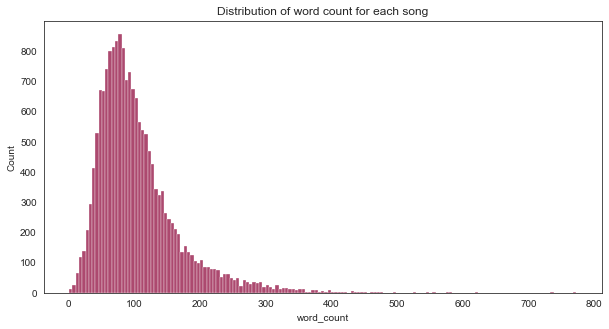

In [74]:
fig = plt.figure(figsize = (10,5))
sns.histplot(data = data, x = 'word_count', color = '#900C3F')
plt.title('Distribution of word count for each song')

plt.show()

In [75]:
def get_top_n_words(corpus, n=None, stopwords = None):
    if stopwords:
        
        vec = CountVectorizer(stop_words  = stopwords).fit(corpus)
    else:
        vec = CountVectorizer().fit(corpus)
    
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    
    return words_freq[:n]



In [76]:
common_words = get_top_n_words(data['lyrics'], 20)
common_words_stop = get_top_n_words(data['lyrics'], 20, 'english')

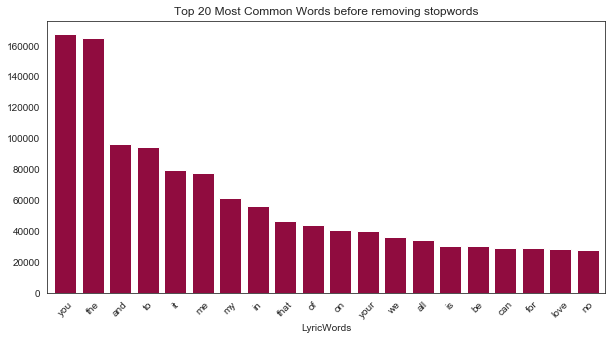

In [77]:
data_plot = pd.DataFrame(common_words, columns = ['LyricWords' , 'count'])

fig = plt.figure(figsize = (10,5))
data_plot.groupby('LyricWords').sum()['count'].sort_values(ascending=False).plot(kind='bar', color = '#900C3F', width=0.8)
plt.xticks(rotation=45)
plt.title('Top 20 Most Common Words before removing stopwords')

plt.show()

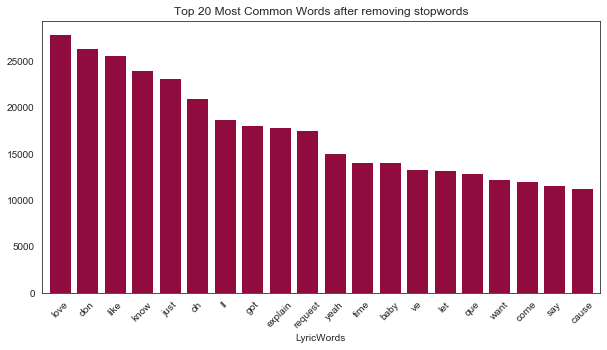

In [79]:
data_plot = pd.DataFrame(common_words_stop, columns = ['LyricWords' , 'count'])

fig = plt.figure(figsize = (10,5))
data_plot.groupby('LyricWords').sum()['count'].sort_values(ascending=False).plot(kind='bar', color = '#900C3F', width=0.8)
plt.xticks(rotation=45)
plt.title('Top 20 Most Common Words after removing stopwords')

plt.show()

In [80]:
common_words_pos = get_top_n_words(data.loc[data.target == 1, 'lyrics'], 10, 'english')
common_words_neg = get_top_n_words(data.loc[data.target == 0, 'lyrics'], 10, 'english')

In [81]:
common_words_pos

[('love', 15676),
 ('don', 15051),
 ('like', 14879),
 ('just', 13008),
 ('know', 13002),
 ('oh', 12726),
 ('got', 11625),
 ('ll', 9876),
 ('que', 9771),
 ('explain', 9511)]

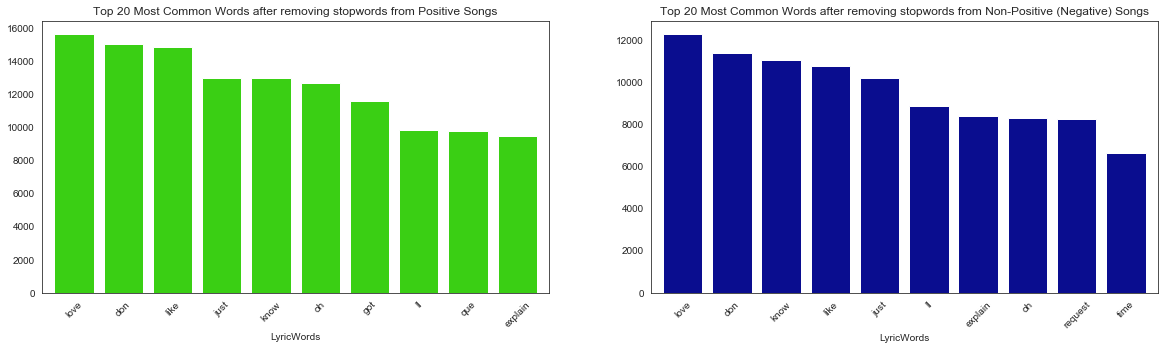

In [82]:
data_plot_pos = pd.DataFrame(common_words_pos, columns = ['LyricWords' , 'count'])
data_plot_neg = pd.DataFrame(common_words_neg, columns = ['LyricWords' , 'count'])

fig, ax = plt.subplots(figsize = (20,5), nrows=1, ncols=2)

plt.subplot(1,2,1)

data_plot_pos.groupby('LyricWords').sum()['count'].sort_values(ascending=False).plot(kind='bar', color = '#3ACF14', width=0.8)
plt.xticks(rotation=45)
plt.title('Top 20 Most Common Words after removing stopwords from Positive Songs')

plt.subplot(1,2,2)

data_plot_neg.groupby('LyricWords').sum()['count'].sort_values(ascending=False).plot(kind='bar', color = '#0A0D8F', width=0.8)
plt.xticks(rotation=45)
plt.title('Top 20 Most Common Words after removing stopwords from Non-Positive (Negative) Songs')

plt.show()

In [83]:
#!pip install wordcloud

In [104]:
STOPWORDS.extend('explain', 'request')

AttributeError: 'set' object has no attribute 'extend'

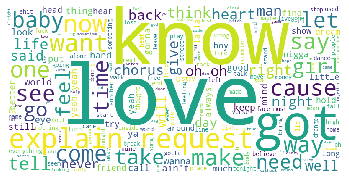

In [84]:
positive_words = ''
for val in data.loc[data['target'] == 1, 'lyrics']:
      
    # typecaste each val to string
    val = str(val)
  
    # split the value
    tokens = val.split()
      
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
      
    positive_words += " ".join(tokens)+" "
    

pos_wordcloud = WordCloud( 
                      stopwords=STOPWORDS,
                      background_color='white',
                      width=800,
                      height=400
            ).generate(positive_words)

plt.imshow(pos_wordcloud)
plt.axis('off')
plt.savefig('../images/wordcloud_pos_songs.png', dpi=300)
plt.show()

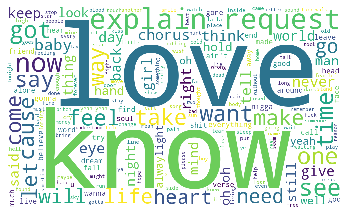

In [85]:
negative_words = ''
for val in data.loc[data['target'] == 0, 'lyrics']:
      
    # typecaste each val to string
    val = str(val)
  
    # split the value
    tokens = val.split()
      
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
      
    negative_words += " ".join(tokens)+" "
    

neg_wordcloud = WordCloud( 
                      stopwords=STOPWORDS,
                      background_color='white',
                      width=1000,
                      height=600
            ).generate(negative_words)

plt.imshow(neg_wordcloud)
plt.axis('off')
plt.savefig('../images/wordcloud_neg_songs.png', dpi=300)
plt.show()

## 3. Train/Test Split
The split between train and test is done here on a random sample of 1000 songs. We will use 20% of the data for `test` and the remaining 80% from `train` 

In [19]:
sample_pos = data.loc[data.target == 1].sample(500, random_state = 1234).reset_index(drop = True)
sample_neg = data.loc[data.target == 0].sample(500, random_state = 1234).reset_index(drop = True)

sample = pd.concat([sample_pos, sample_neg], axis = 0)

print(sample.shape)

(1000, 8)


In [20]:
X = sample['lyrics_pre_proc']
y = sample['target']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [22]:
X_train.shape, X_test.shape

((800,), (200,))

## 4. Feature Engineering

We need to map integers to each word. To do that, we built a function that will take as input the individual pre-processed words of a lyric and output a dictionary to an unique integer

In [26]:
words = []
    
for lyric in sample['lyrics_pre_proc']:
    for word in lyric:
        words.append(word)
    
unique_words = sorted(Counter(words).keys())

In [27]:
unique_words

['0',
 '000',
 '10',
 '100',
 '1000',
 '101',
 '10day',
 '11',
 '12',
 '1201',
 '13',
 '14th',
 '15',
 '16',
 '17',
 '18',
 '1845',
 '19',
 '1941',
 '1948',
 '1954',
 '1959',
 '1961',
 '1962',
 '1964',
 '1965',
 '1971',
 '1973',
 '1975',
 '1979',
 '1983',
 '1989',
 '1993',
 '1996',
 '1998',
 '1da',
 '1ll',
 '1st',
 '1x',
 '20',
 '200',
 '2000',
 '2003',
 '2015',
 '2018',
 '22',
 '23',
 '23rd',
 '24',
 '25',
 '2boom',
 '2d',
 '2low',
 '2nd',
 '2pac',
 '2x',
 '3',
 '30',
 '305',
 '31',
 '310',
 '33',
 '36',
 '360',
 '38',
 '39',
 '3rd',
 '3x',
 '4',
 '40',
 '4117',
 '4128',
 '42',
 '44',
 '45',
 '4am',
 '4th',
 '4x',
 '4x4',
 '5',
 '50',
 '5000',
 '5001',
 '50k',
 '51',
 '51st',
 '52nd',
 '55',
 '58',
 '59',
 '5th',
 '5x',
 '6',
 '64',
 '65',
 '6803',
 '69',
 '6th',
 '6x',
 '7',
 '70',
 '73',
 '745',
 '76',
 '767',
 '78',
 '7am',
 '7x',
 '8',
 '808',
 '82',
 '84',
 '84th',
 '88',
 '9',
 '90',
 '911',
 '92',
 '93',
 '94',
 '96',
 '98',
 '99',
 '990',
 'aam',
 'abandon',
 'abhor',
 'abid',

In [28]:
len(unique_words)

5868

In [29]:
def build_dict(data, vocab_size):
    """Construct and return a dictionary mapping each of the most frequently appearing words to a unique integer."""
    
    words = []
    
    for lyric in data:
        for word in lyric:
            words.append(word)
    
    unique_words = Counter(words).keys()
    counts = Counter(words).values()

    word_count = dict(zip(unique_words, counts)) # A dict storing the words that appear in the reviews along with how often they occur
    
    sorted_words = list({k: v for k, v in sorted(word_count.items(), key=lambda item: item[1], reverse = True)}.keys())
    
    word_dict = {} 
    for idx, word in enumerate(sorted_words[:vocab_size - 2]): 
        word_dict[word] = idx + 2                             
    
    return word_dict

In [30]:
word_dict = build_dict(X_train, vocab_size = 3000)

In [31]:
word_dict

{'love': 2,
 'like': 3,
 'know': 4,
 'got': 5,
 'oh': 6,
 'time': 7,
 'get': 8,
 'let': 9,
 'go': 10,
 'come': 11,
 'one': 12,
 'yeah': 13,
 'make': 14,
 'babi': 15,
 'never': 16,
 'see': 17,
 'way': 18,
 'la': 19,
 'take': 20,
 'say': 21,
 'need': 22,
 'want': 23,
 'away': 24,
 'feel': 25,
 'caus': 26,
 'day': 27,
 'night': 28,
 'life': 29,
 'back': 30,
 'think': 31,
 'heart': 32,
 'girl': 33,
 'de': 34,
 'tell': 35,
 'right': 36,
 'could': 37,
 'littl': 38,
 'man': 39,
 'keep': 40,
 'said': 41,
 'good': 42,
 'give': 43,
 'look': 44,
 'still': 45,
 'well': 46,
 'world': 47,
 'around': 48,
 'tri': 49,
 'find': 50,
 'us': 51,
 'fall': 52,
 'hey': 53,
 'everi': 54,
 'would': 55,
 'alway': 56,
 'mi': 57,
 'turn': 58,
 'te': 59,
 'wait': 60,
 'mind': 61,
 'ya': 62,
 'live': 63,
 'new': 64,
 'hold': 65,
 'insid': 66,
 'long': 67,
 'someon': 68,
 'thing': 69,
 'everyth': 70,
 'walk': 71,
 'yo': 72,
 'home': 73,
 'better': 74,
 'head': 75,
 'leav': 76,
 'light': 77,
 'hear': 78,
 'call': 79,


In [33]:
assert len(word_dict) == 3000 - 2 #we should have 3000 - 2 mappings

We leave the categories 0 and 1 for the "no word" category and "infrequent" word

In [34]:
def convert_and_pad(word_dict, sentence, pad=500):
    NOWORD = 0 # We will use 0 to represent the 'no word' category
    INFREQ = 1 # and we use 1 to represent the infrequent words, i.e., words not appearing in word_dict
    
    working_sentence = [NOWORD] * pad
    
    for word_index, word in enumerate(sentence[:pad]):
        if word in word_dict:
            working_sentence[word_index] = word_dict[word]
        else:
            working_sentence[word_index] = INFREQ
            
    return working_sentence, min(len(sentence), pad)

def convert_and_pad_data(word_dict, data, pad=500):
    result = []
    lengths = []
    
    for sentence in data:
        converted, leng = convert_and_pad(word_dict, sentence, pad)
        result.append(converted)
        lengths.append(leng)
        
    return np.array(result), np.array(lengths)

In [35]:
X_train, X_train_len = convert_and_pad_data(word_dict, X_train)
X_test, X_test_len = convert_and_pad_data(word_dict, X_test)

In [36]:
song = 456
print(X_train[song])
#print(X_train_len[1])

[207   6  22 207   2 207   8 207 175  17  55  43  47  24 142  22  54  28
 543  11 268  29  55   2 214 130   7  31  54 474  10 159 197 163  11 116
  17  55  43  47  24 142   6  22  54  28 543  11 268  29  55   2 214 130
   7  35  22   9  43 212 114 118 315  25  35  22   9  43  70  54 474 378
 130   7  55   2 214 130   7   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   

In [37]:
pd.DataFrame(X_train).to_csv('../data/output/xtrain.csv', header = False, index = False)
pd.DataFrame(y_train).to_csv('../data/output/ytrain.csv', header = False, index = False)

pd.DataFrame(X_test).to_csv('../data/output/xtest.csv', header = False, index = False)
pd.DataFrame(y_test).to_csv('../data/output/ytest.csv', header = False, index = False)

In [38]:
X_train

array([[   7,   93,  819, ...,    0,    0,    0],
       [1368,  122, 1275, ...,    0,    0,    0],
       [ 994,  894,  637, ...,    0,    0,    0],
       ...,
       [ 676,  326,   78, ...,    0,    0,    0],
       [2148, 2148, 1234, ...,    0,    0,    0],
       [ 138,   76,   77, ...,    0,    0,    0]])

In [39]:
cache_dir = os.path.join("../cache", "mappings")  # where to store cache files
os.makedirs(cache_dir, exist_ok=True)
cache_file="word_dict.pkl"

with open(os.path.join(cache_dir, cache_file), 'wb') as f:
    cache_data = pickle.dump(word_dict, f)

In [40]:
cache_dir = os.path.join("../cache", "lyrics")  # where to store cache files
os.makedirs(cache_dir, exist_ok=True)
cache_file="preprocessed_data.pkl"

with open(os.path.join(cache_dir, cache_file), 'wb') as f:
    cache_data = pickle.dump(data, f)